In [2]:
import torch
import argparse
import matplotlib.pyplot as plt
import numpy as np

from load_model import load_model
from bayes_radd import mc_marginal  # assume these are defined in bayesRADD
import data

MODEL_PATH   = "JingyangOu/radd-t-dce"
SEQ_LEN      = 1024
BATCH_SIZE   = 16
MAX_BATCHES  = 1
K_CALIB      = 32
K_OOD        = 8
N_BINS       = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, noise = load_model(MODEL_PATH, device)
model.eval()

def build_loader():
    args = argparse.Namespace(
        cache_dir="data", batch_size=BATCH_SIZE,
        length=SEQ_LEN, valid_dataset="wikitext2", ngpus=1
    )
    return data.get_valid_dataloaders(args, distributed=False)

In [21]:
# 1) grab a single sequence
loader   = build_loader()
batch    = next(iter(loader))
x_batch  = batch["input_ids"].to(device)   # [B,T]
x_single = x_batch[0:1]                    # [1,T]

# 2) run your MC marginal with K=1 (single pass) so we see the raw-conf behavior
K = 32
mc_p, _ = mc_marginal(model, noise, x_single, K)  # returns [1,T,V] marginals

# 3) inspect the top‐prob (“confidence”) for the first few tokens
probs, preds = mc_p.max(dim=-1)            # [1,T] each
print("True tokens   :", x_single[0, :20].tolist())
print("Predictions   :", preds[0, :20].tolist())
print("Confidences   :", probs[0, :20].tolist())

# 4) you can also print the unique confidences:
#print("Unique confidences:", torch.unique(probs).tolist())

True tokens   : [318, 45735, 416, 262, 4901, 326, 674, 11202, 24748, 893, 691, 257, 13027, 3950, 11, 326, 3950, 2346, 318, 48048]
Predictions   : [318, 1912, 416, 262, 1109, 326, 262, 1570, 24748, 893, 691, 257, 286, 3872, 11, 326, 3950, 2346, 318, 11]
Confidences   : [0.14075994491577148, 0.04275982081890106, 0.1959110051393509, 0.2803007662296295, 0.11967562884092331, 0.4353092312812805, 0.10774314403533936, 0.0646200031042099, 0.19869589805603027, 0.3283914625644684, 0.17387226223945618, 0.16028423607349396, 0.07155800610780716, 0.05779648199677467, 0.2975394129753113, 0.06902003288269043, 0.10107185691595078, 0.056412920355796814, 0.30353817343711853, 0.0341607965528965]


In [22]:
sum((x_single == preds)[0].tolist()) / len(x_single[0])

0.5966796875

K = 1  | 0.15
K = 4  | 0.30
K = 8  | 0.49
K = 16 | 0.55
K = 32 | 0.60

Ent→Err K=32:   0%|          | 0/1 [00:00<?, ?it/s]

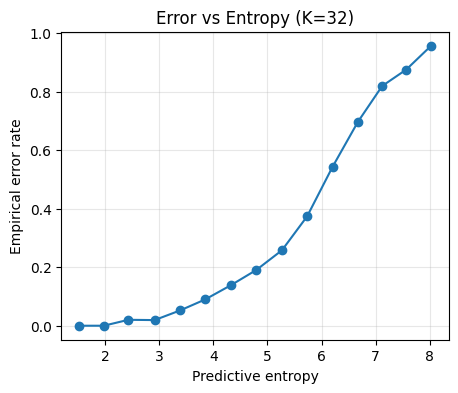

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from bayes_radd import mc_marginal

@torch.no_grad()
def entropy_error_curve(model, noise, device, dataloader, K, n_bins=20, max_batches=None):
    all_H   = []
    all_err = []

    length = min(max_batches, len(dataloader)) if max_batches else len(dataloader)
    for i, batch in enumerate(tqdm(dataloader, total=length, desc=f"Ent→Err K={K}")):
        if max_batches and i >= max_batches:
            break

        x = batch["input_ids"].to(device)    # [B,T]
        B, T = x.shape

        mc_p, _  = mc_marginal(model, noise, x, K)  # [B,T,V']
        pred     = mc_p.argmax(dim=-1)              # [B,T]
        err      = (pred != x).float()              # [B,T]

        # compute per-token entropy
        H = -(mc_p * mc_p.clamp(min=1e-12).log()).sum(dim=-1)  # [B,T]

        all_H.append(H.view(-1).cpu().numpy())
        all_err.append(err.view(-1).cpu().numpy())

    H   = np.concatenate(all_H)
    err = np.concatenate(all_err)
    N   = H.shape[0]

    bins = np.linspace(H.min(), H.max(), n_bins+1)
    centers = 0.5*(bins[:-1] + bins[1:])
    err_rate = np.zeros(n_bins)
    avg_H    = np.zeros(n_bins)
    counts   = np.zeros(n_bins)

    for b in range(n_bins):
        m = (H >= bins[b]) & (H < bins[b+1])
        counts[b] = m.sum()
        if counts[b]>0:
            err_rate[b] = err[m].mean()
            avg_H[b]    = H[m].mean()

    return centers, avg_H, err_rate, counts

# ——— in your notebook ———
K = 32
centers, avg_H, err_rate, counts = entropy_error_curve(
    model, noise, device, build_loader(), K, n_bins=15, max_batches=MAX_BATCHES
)

plt.figure(figsize=(5,4))
plt.plot(avg_H, err_rate, marker='o')
plt.xlabel("Predictive entropy")
plt.ylabel("Empirical error rate")
plt.title(f"Error vs Entropy (K={K})")
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
from scipy.stats import spearmanr

# compute Spearman’s rho and p‐value
rho, pval = spearmanr(avg_H, err_rate)

print(f"Spearman ρ = {rho:.3f}, p = {pval:.3g}")

Spearman ρ = 0.996, p = 1.03e-14


Calib K=32:   0%|          | 0/1 [00:00<?, ?it/s]

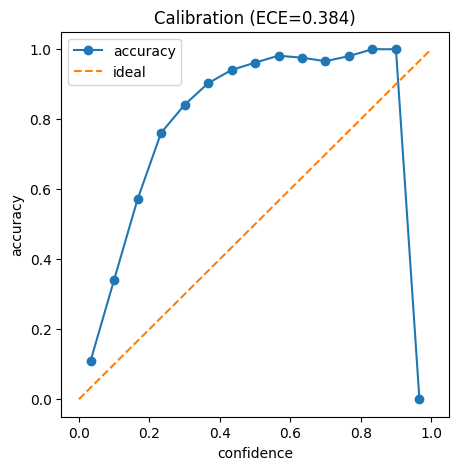

ECE: 0.3843080799285872


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_radd import mc_marginal

# ——— 6) Calibration pass over dataset ————————
@torch.no_grad()
def calibration_curve(model, noise, device, dataloader, K, n_bins=15, max_batches=None):
    all_conf, all_corr = [], []

    length = min(max_batches, len(dataloader)) if max_batches else len(dataloader)
    for i, batch in enumerate(tqdm(dataloader, total=length, desc=f"Calib K={K}")):
        if max_batches and i >= max_batches:
            break
        x = batch["input_ids"].to(device)   # [B,T]
        mc_p, _   = mc_marginal(model, noise, x, K)  # [B,T,V']
        p_conf, p_pred = mc_p.max(dim=-1)            # over V'
        corr = (p_pred == x).float()                 # [B,T]

        all_conf.append(p_conf.view(-1).cpu().numpy())
        all_corr.append(corr.view(-1).cpu().numpy())

    conf = np.concatenate(all_conf)
    corr = np.concatenate(all_corr)
    bins = np.linspace(0,1,n_bins+1)
    centers = (bins[:-1]+bins[1:])/2
    accuracies = np.zeros(n_bins)
    confidences= np.zeros(n_bins)
    counts     = np.zeros(n_bins)
    N = conf.shape[0]

    for b in range(n_bins):
        # include rightmost edge in last bin
        if b == n_bins-1:
            mask = (conf>=bins[b]) & (conf<=bins[b+1])
        else:
            mask = (conf>=bins[b]) & (conf< bins[b+1])
        counts[b] = mask.sum()
        if counts[b]>0:
            accuracies[b]   = corr[mask].mean()
            confidences[b]  = conf[mask].mean()

    ece = np.sum((counts/N) * np.abs(accuracies - confidences))
    return centers, accuracies, confidences, counts, ece

K_CALIB = 32
bins, accs, confs, counts, ece = calibration_curve(
    model, noise, device, build_loader(), K_CALIB, n_bins=15, max_batches=MAX_BATCHES
)

plt.figure(figsize=(5,5))
plt.plot(bins, accs, marker='o', label='accuracy')
plt.plot([0,1],[0,1],'--', label='ideal')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.title(f'Calibration (ECE={ece:.3f})')
plt.legend()
plt.show()
print("ECE:", ece)